# Parking spot detection

In [1]:
## setup

import os
import sys
import shutil
import zipfile
import xml.etree.ElementTree as ET

import os
from PIL import Image
from ultralytics import YOLO


## Dataset
[The dataset](https://www.kaggle.com/datasets/blanderbuss/parking-lot-dataset) consists of multiple images from parking lots in different moments (cloudy, sunny, rainy).


## Data Preprocessing

In [1]:
path_to_zip_file = "data/archive.zip"
directory_to_extract_to = "data/"

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

### Merge all folders into one

In [2]:
source_folders = [
    "data/PKLot/PKLot/PKLot/PUCPR/Cloudy",
    "data/PKLot/PKLot/PKLot/PUCPR/Sunny",
    "data/PKLot/PKLot/PKLot/PUCPR/Rainy",
    "data/PKLot/PKLot/PKLot/UFPR04/Cloudy",
    "data/PKLot/PKLot/PKLot/UFPR04/Sunny",
    "data/PKLot/PKLot/PKLot/UFPR04/Rainy",
    "data/PKLot/PKLot/PKLot/UFPR05/Cloudy",
    "data/PKLot/PKLot/PKLot/UFPR05/Sunny",
    "data/PKLot/PKLot/PKLot/UFPR05/Rainy"
]

destination_folder = "data/total-content"

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Iterate through source folders and merge contents
for source_folder in source_folders:
    for root, _, files in os.walk(source_folder):
        for file in files:
            source_file_path = os.path.join(root, file)
            destination_file_path = os.path.join(destination_folder, file)
            shutil.copy(source_file_path, destination_file_path)

print("Contents merged successfully.")

Contents merged successfully.


In [3]:
input_folder = "data/total-content"
output_folder = "data/labels-xml"

image_width = 1280
image_height = 720

class_mapping = {"1": 1, "0": 0}

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

xml_files = [f for f in os.listdir(input_folder) if f.endswith(".xml")]
for xml_file in xml_files:
    xml_path = os.path.join(input_folder, xml_file)
    
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    txt_filename = os.path.splitext(xml_file)[0] + ".txt"
    txt_path = os.path.join(output_folder, txt_filename)

    with open(txt_path, "w") as txt_file:
        for space in root.findall("space"):
            occupied = space.get("occupied")
            class_index = class_mapping.get(occupied, -1)
            
            if class_index == -1:
                continue
            
            rotated_rect = space.find("rotatedRect")
            center = rotated_rect.find("center")
            size = rotated_rect.find("size")
            
            center_x = float(center.get("x"))
            center_y = float(center.get("y"))
            width = float(size.get("w"))
            height = float(size.get("h"))
            
            x_center = center_x / image_width
            y_center = center_y / image_height
            w = width / image_width
            h = height / image_height
            
            txt_file.write(f"{class_index} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")
    
    new_xml_path = os.path.join(output_folder, xml_file)
    os.rename(xml_path, new_xml_path)

print("Annotations generated and XML files moved.")

Annotations generated and XML files moved.


In [4]:
# Move the txt files from the xml folder to the total-content folder

source_folder = "data/labels-xml"
destination_folder = "data/total-content"

txt_files = [f for f in os.listdir(source_folder) if f.endswith(".txt")]

for txt_file in txt_files:
    source_path = os.path.join(source_folder, txt_file)
    destination_path = os.path.join(destination_folder, txt_file)
    shutil.move(source_path, destination_path)

print("TXT files moved to data/total-content folder.")

TXT files moved to data/total-content folder.


### Train - Test - Val folders split

In [8]:
# remove the image that has no corresponding txt file

file_path = "data/total-content/2012-11-06_18_48_46.jpg"
try:
    os.remove(file_path)
    print(f"File '{file_path}' has been removed successfully.")
except OSError as e:
    print(f"Error removing the file '{file_path}': {e}")


source_folder = "data/total-content"
train_folder = "data/train"
test_folder = "data/test"
val_folder = "data/val"

train_ratio = 0.7
test_ratio = 0.15
val_ratio = 0.15

for folder in [train_folder, test_folder, val_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)

all_files = os.listdir(source_folder)
image_files = [f for f in all_files if f.endswith(".jpg")]

# Calculate the number of samples for each split
num_samples = len(image_files)
num_train = int(train_ratio * num_samples)
num_test = int(test_ratio * num_samples)
num_val = num_samples - num_train - num_test

random.shuffle(image_files)

train_files = image_files[:num_train]
test_files = image_files[num_train:num_train + num_test]
val_files = image_files[num_train + num_test:]

# Move corresponding txt files along with images
for folder, files in [(train_folder, train_files), (test_folder, test_files), (val_folder, val_files)]:
    for file in files:
        # Move image file
        source_image_path = os.path.join(source_folder, file)
        destination_image_path = os.path.join(folder, file)
        shutil.move(source_image_path, destination_image_path)
        
        # Move corresponding txt file
        txt_file = os.path.splitext(file)[0] + ".txt"
        source_txt_path = os.path.join(source_folder, txt_file)
        destination_txt_path = os.path.join(folder, txt_file)
        shutil.move(source_txt_path, destination_txt_path)

print("Data split into train, test, and val sets.")

File 'data/total-content/2012-11-06_18_48_46.jpg' has been removed successfully.
Data split into train, test, and val sets.


In [9]:
# Organize the datasets into the following structure:
# data.zip
# ├── images
# │   ├── train
# │   ├── val
# │   └── test
# └── labels
#     ├── train
#     ├── val
#     └── test


datasets = ['train', 'val', 'test']
source_folder = 'data'

for dataset in datasets:
	dataset_folder = os.path.join(source_folder, dataset)
	
	# Create "images" and "labels" folders
	images_folder = os.path.join(dataset_folder, "images")
	labels_folder = os.path.join(dataset_folder, "labels")
	os.makedirs(images_folder, exist_ok=True)
	os.makedirs(labels_folder, exist_ok=True)
	
	# Organize image and label files
	for file in os.listdir(dataset_folder):
		if file.endswith(".jpg"):
			image_path = os.path.join(dataset_folder, file)
			image_destination = os.path.join(images_folder, file)
			shutil.move(image_path, image_destination)
		elif file.endswith(".txt"):
			label_path = os.path.join(dataset_folder, file)
			label_destination = os.path.join(labels_folder, file)
			shutil.move(label_path, label_destination)

print("Datasets organized successfully.")

Datasets organized successfully.


## Model Loading 

In [1]:
import os
print(os.getcwd())

from ultralytics import YOLO  # Import YOLO from ultralytics

# Load the YOLO model 
model = YOLO("models/parking-lot-prediction_ultralytics-100e-2.pt")

g:\Project-repo


## Prediction on test set

In this section we will be using Trained model to predict the bounding boxes and classes of the images in the test set. A random image will be taken from the test set. The amount of bounding boxes will be shown first and then the image with the bounding boxes and classes. 

In [12]:
import random
from PIL import Image  # Import PIL to handle image display
import numpy as np  # Import numpy to handle array manipulations if needed


# Define the path to your test images directory
test_images_directory = "./data/images/images"

# Get a list of all .jpg image files in the directory
image_files = [f for f in os.listdir(test_images_directory) if f.lower().endswith(".jpg")]

# Randomly select one image file from the list
random_image_filename = random.choice(image_files)
random_image_path = os.path.join(test_images_directory, random_image_filename)

# Perform model prediction on the selected image
results = model.predict(random_image_path)
result = results[0]

# Print the number of detected objects
print(f"\nDetected {len(result.boxes)} object(s):")

# Loop through detected boxes and print a simple output
for box in result.boxes:
    label = result.names[box.cls[0].item()]
    prob = round(box.conf[0].item(), 4)
    # print(f"Object: {label} | Confidence: {prob}")


image 1/1 g:\Project-repo\data\images\images\2012-09-13_16_55_33.jpg: 384x640 31 emptys, 72 occupieds, 81.0ms
Speed: 1.0ms preprocess, 81.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

Detected 103 object(s):


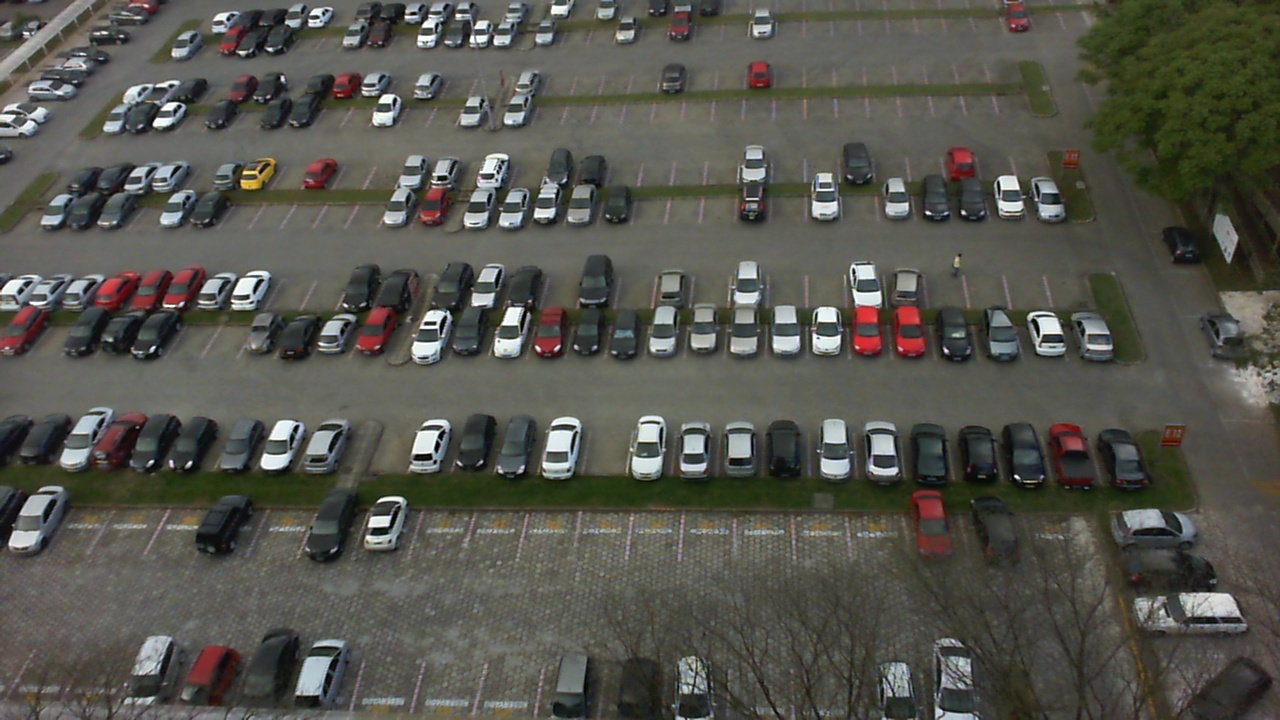

In [13]:
# Display the original image
# print("# Original Image")
# Image.open(random_image_path).show()

# Original image
Image.open(random_image_path)

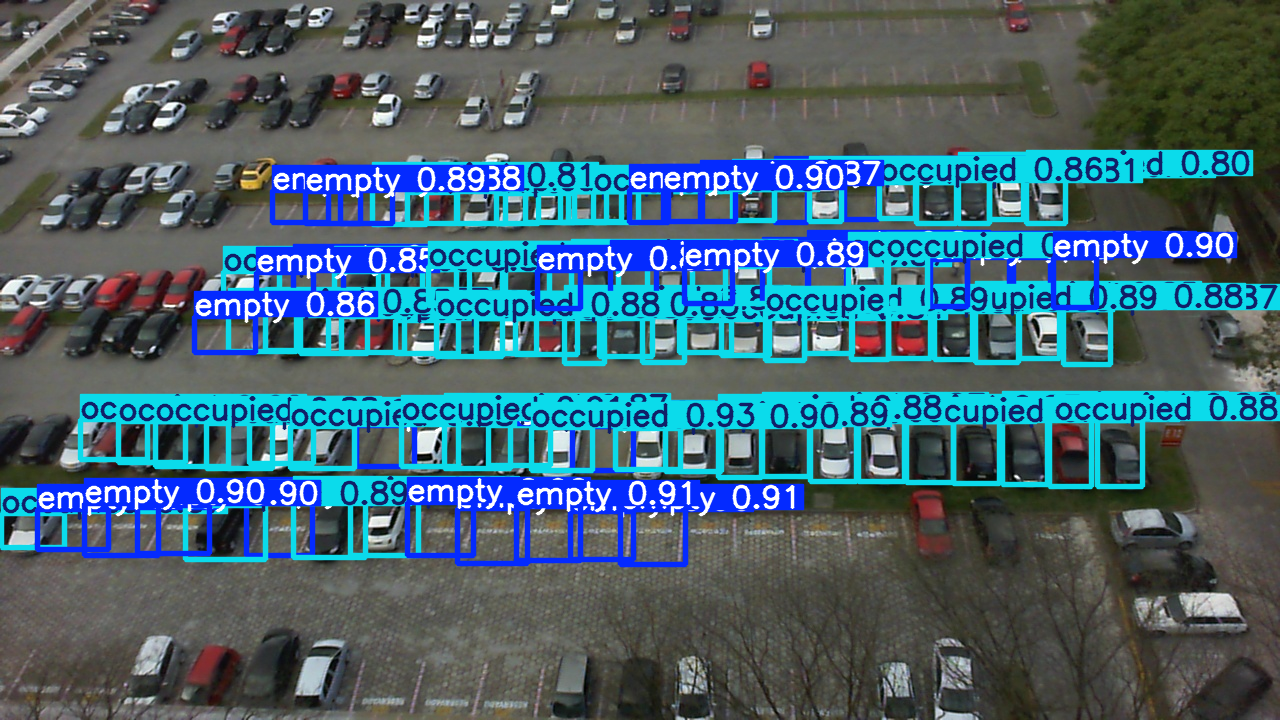

In [14]:
# Display the image with results overlaid
# print("\n# Image with Model Results")

Image.fromarray(result.plot()[:, :, ::-1])

----------------------------------------------------------------------------------------------------------